# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot  as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


# Data exploration

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

Our data consists of two csv files prepared for training and testing. In training data we have 18524 records, in testing 6175 records.

In [3]:
print(train_data.shape)
print(test_data.shape)
print(train_data.dtypes)

(18524, 9)
(6175, 8)
id                             int64
Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object


Data have some missing values, it is important to handle it. For now let's stay with raw data.

In [4]:
print("TRAIN")
print(train_data.isna().sum())
print("TEST")
print(test_data.isna().sum())

TRAIN
id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64
TEST
id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


In [5]:
train_data.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


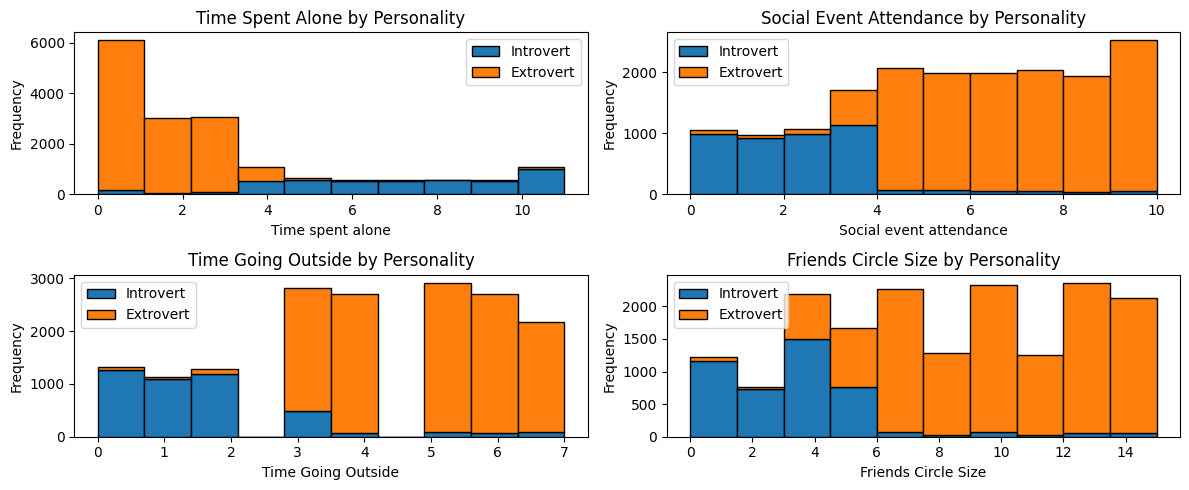

In [6]:
introverts = train_data[train_data.Personality == 'Introvert']
extroverts = train_data[train_data.Personality == 'Extrovert']

fig, axs = plt.subplots(2, 2, figsize=(12, 5))

colors = ['#1f77b4', '#ff7f0e']  # niebieski, pomarańczowy
labels = ['Introvert', 'Extrovert']

# 1. Time spent alone
axs[0][0].hist(
    [introverts.Time_spent_Alone, extroverts.Time_spent_Alone],
    bins=10,
    stacked=True,
    label=labels,
    color=colors,
    edgecolor='black'
)
axs[0][0].set_xlabel('Time spent alone')
axs[0][0].set_ylabel('Frequency')
axs[0][0].set_title('Time Spent Alone by Personality')
axs[0][0].legend()

# 2. Social event attendance
axs[0][1].hist(
    [introverts.Social_event_attendance, extroverts.Social_event_attendance],
    bins=10,
    stacked=True,
    label=labels,
    color=colors,
    edgecolor='black'
)
axs[0][1].set_xlabel('Social event attendance')
axs[0][1].set_ylabel('Frequency')
axs[0][1].set_title('Social Event Attendance by Personality')
axs[0][1].legend()

# 3. Time going outside
axs[1][0].hist(
    [introverts.Going_outside, extroverts.Going_outside],
    bins=10,
    stacked=True,
    label=labels,
    color=colors,
    edgecolor='black'
)
axs[1][0].set_xlabel('Time Going Outside')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_title('Time Going Outside by Personality')
axs[1][0].legend()

# 4. Friends circle size
axs[1][1].hist(
    [introverts.Friends_circle_size, extroverts.Friends_circle_size],
    bins=10,
    stacked=True,
    label=labels,
    color=colors,
    edgecolor='black'
)
axs[1][1].set_xlabel('Friends Circle Size')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_title('Friends Circle Size by Personality')
axs[1][1].legend()
plt.tight_layout()
plt.show()


# Prepare Data

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select target variable
y = train_data.Personality
train_data.drop(["Personality"], axis=1, inplace=True)

# Split to taining and validation
X_train_full, X_valid_full, y_train, y_valid_raw = train_test_split(train_data, y, train_size=0.8, test_size=0.2, random_state=0)

# Get categorical features names
categorical_features = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == 'object']
print("Categorical features: ", categorical_features)

# Get low cardinality features
low_cardinality_features = [cname for cname in categorical_features if X_train_full[cname].nunique() < 10]
print("Low cardinality features: ", low_cardinality_features)

# Get numeric columns
numeric_features = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int', 'float']]

# Filter redundant columns from train, test and valid
selected_features = low_cardinality_features + numeric_features

X_train = X_train_full[selected_features].copy()
X_valid = X_valid_full[selected_features].copy()
X_test = test_data[selected_features].copy()

# Encode categorical target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid_raw)

Categorical features:  ['Stage_fear', 'Drained_after_socializing']
Low cardinality features:  ['Stage_fear', 'Drained_after_socializing']


# Define Pipeline

# 

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


# Test For Best Parameters

In [9]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

def get_score(n_estimators, cv, lr, X, y):
    """Return the average MAE over CV folds of XGBClassifier.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(n_estimators=n_estimators, learning_rate=lr, random_state=0))
    ])
    
    scores = cross_val_score(pipeline, X, y,
                                 cv=cv,
                                 scoring='accuracy')
    return scores.mean()
    
def plot_results():
    pass
    
results = {n_estimators: get_score(n_estimators, 5, 0.01, X_train, y_train) for n_estimators in np.arange(50, 600, 50)}


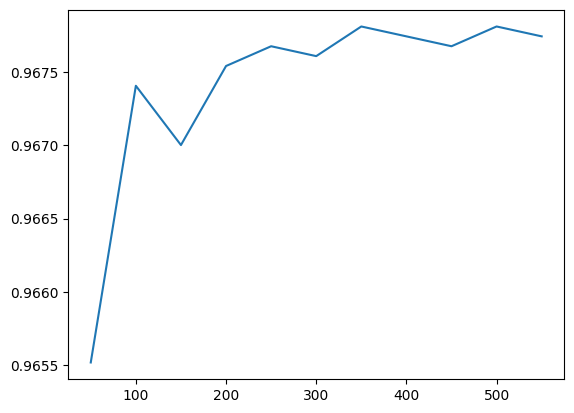

In [10]:
plt.plot(list(results.keys()), list(results.values()))
plt.show()

# Define Best model

In [11]:
pipeline_XGBClassifier = Pipeline(steps=[
    ('prepocessor', preprocessor),
    ('model', XGBClassifier(n_estimators=350, learning_rate=0.01, random_state=0))
])

pipeline_XGBClassifier.fit(X_train, y_train)

Pipeline(steps=[('prepocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['id', 'Time_spent_Alone',
                                                   'Social_event_attendance',
                                                   'Going_outside',
                                                   'Friends_circle_size',
                                                   'Post_frequency']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Stage_fear',
                                                   'Drained_after_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=350, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

# Test Model

In [12]:
from sklearn.metrics import accuracy_score

predictions = pipeline_XGBClassifier.predict(X_valid)

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy: ", accuracy)

Accuracy:  0.9686909581646423


# Final Prediction

In [13]:
final_prediction = pipeline_XGBClassifier.predict(X_test)

In [14]:
final_prediction = label_encoder.inverse_transform(final_prediction)

In [15]:
submission = pd.DataFrame({
    "id": X_test["id"],
    "pred_class": final_prediction
})

In [16]:
submission.to_csv("submission.csv", index=False)